In [ ]:
!pip install pyspark
!pip install spotipy
!pip install urllib3==1.26
!pip install requests==2.25

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import urllib3
import requests
import json
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from google.colab import drive
from oauth2client.client import GoogleCredentials
import io
import zipfile
import glob
import pprint as pp #Pretty printer
from itertools import chain
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm
import os
import pandas as pd
import threading
from concurrent.futures import ThreadPoolExecutor
from pyspark.sql.functions import explode, mean, desc,col
from pyspark.sql.types import StructType
import shutil

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Putting Data in Drive

In [ ]:
filtered1, filtered2, filtered3, filtered4 = filtered2[:25],filtered2[25:50],filtered2[50:75],filtered2[75:100] #slicing the data to 8 files

In [ ]:
import json
from google.colab import files
#dumping the data into jsons
#this only shows 4 files because we had to do this over two runtimes due to RAM limitations
with open('filtered1.json', 'w') as f:
    json.dump(filtered1, f)
del filtered1

with open('filtered2.json', 'w') as f:
    json.dump(filtered2, f)
del filtered2

with open('filtered3.json', 'w') as f:
    json.dump(filtered3, f)
del filtered3

with open('filtered4.json', 'w') as f:
    json.dump(filtered4, f)
del filtered4


In [ ]:
import shutil
#dumping jsons to drive
colab_link1 = "/content/filtered5.json"
colab_link2 = "/content/filtered6.json"
colab_link3 = "/content/filtered7.json"
colab_link4 = "/content/filtered8.json"


gdrive_link = "/content/gdrive/MyDrive/BDA_Final_Project/"

shutil.copy(colab_link1, gdrive_link)
shutil.copy(colab_link2, gdrive_link)
shutil.copy(colab_link3, gdrive_link)
shutil.copy(colab_link4, gdrive_link)

'/content/gdrive/MyDrive/BDA_Final_Project/filtered8.json'

#Loading Data

In [ ]:
spark = SparkSession.builder.appName('sparkspot').getOrCreate() #creating spark session

In [ ]:
dflist = []
counter = 0 #loading json files from google drive
for json_file in glob.glob("/content/gdrive/MyDrive/BDA_Final_Project/*.json"): 
  dflist.append(spark.read.json('/content/gdrive/MyDrive/BDA_Final_Project/filtered1.json',multiLine=True))

In [ ]:
dflist2 = [] #exploding concatenated tracks column
for df in dflist:
  dftemp = df.select(explode('playlists')).select(explode('col.tracks'),'col.name','col.pid',
  'col.num_followers', 'col.num_tracks','col.duration_ms','col.num_artists').withColumnRenamed("duration_ms","p_duration_ms").select('col.*','*').drop('col')
  dflist2.append(dftemp)

In [ ]:
dflist2[0].printSchema()

In [ ]:
data_rdd = dflist2[0].rdd #transforming to rdd

In [ ]:
dfc = dflist2[0] #creating a dataframe from the union of all dataframes
for df in dflist2[1:4]:
  dfc = dfc.union(df)

#Extracting feats

In [ ]:
uris = []
for df in dflist2:
  uris.extend(df.select('track_uri').distinct().collect())

In [ ]:
uris = list(set(uris))
uris = [i.asDict() for i in uris]
uris = [i['track_uri'] for i in uris]

In [ ]:
uris = [i.asDict() for i in uris]
uris = [i['track_uri'] for i in uris]

In [ ]:
uri2 = list(set(uris))

In [ ]:
uris = []
with open('uris.json', "rb") as infile:
      uris.extend(json.load(infile))
feats = []
with open('feats1.json', "rb") as infile:
      feats.extend(json.load(infile))

In [ ]:
feats = [i['uri'] for i in feats if i != None]
uris = list(set(uris) - set(feats))

In [ ]:
colab_link1 = "/content/uris.json"
colab_link2 = "/content/feats1.json"


gdrive_link = "/content/gdrive/MyDrive/BDA_Final_Project/uri_feats/"

shutil.copy(colab_link1, gdrive_link)
shutil.copy(colab_link2, gdrive_link)

'/content/gdrive/MyDrive/BDA_Final_Project/uri_feats/feats1.json'

In [ ]:
import time
def search_song(track_uri: str):
    feature = None
    while type(feature) != list:
      feature = sp.audio_features(track_uri)
    audio_feats.extend(feature[0])
    return

In [ ]:
# Spotify credentials
auth_manager = SpotifyClientCredentials(client_id='f354e90a115c46abb51ab4ebfdb55ce9', client_secret='c')
sp = spotipy.client.Spotify(auth_manager=auth_manager)
audio_feats = []
executor = ThreadPoolExecutor(12)
futures = []
for track in uris:
    track_uri = track.split(":")[2]
    future = executor.submit(search_song, (track_uri))
    futures.append(future)
    uris.remove(track)

In [ ]:
audio_feats[1]

'energy'

In [ ]:
type((1,2)) == list

False

#Analytics Jobs

##Most Popular Tracks

In [ ]:
top_tracks = dfc.groupBy("track_name").count().orderBy(desc("count")).take(10)

In [ ]:
top_tracks = [i.asDict() for i in top_tracks]

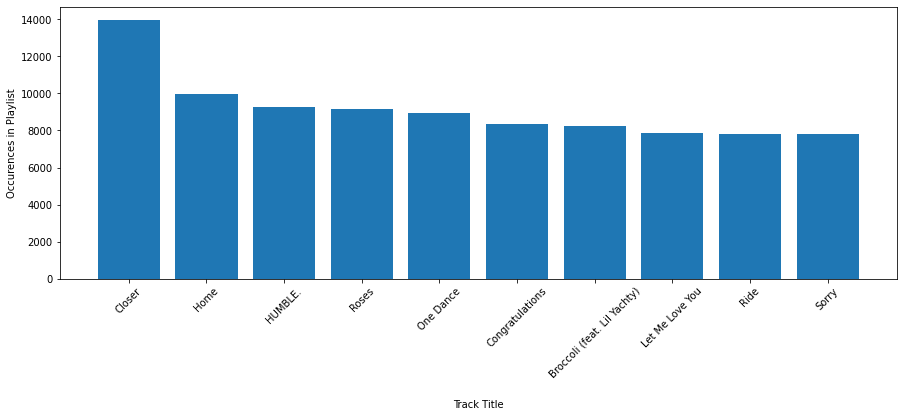

In [ ]:
tracks = []
count = []
for k in top_tracks:
    tracks.append(k['track_name']) #replacing champID by champion name
    count.append(k['count'])
f, ax = plt.subplots(figsize=(15,5))
plt.bar(tracks,count);
plt.xlabel("Track Title", labelpad = 20);
plt.xticks(rotation = 45);
plt.ylabel("Occurences in Playlist");

##Most Popular Artists

In [ ]:
top_artists = dfc.groupBy("artist_name").count().orderBy(desc("count")).take(10)

In [ ]:
top_artists = [i.asDict() for i in top_artists]

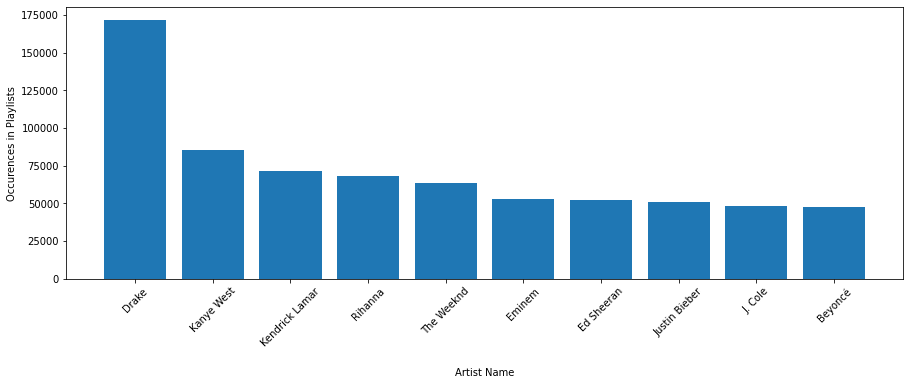

In [ ]:
artists = []
count = []
for k in top_artists:
    artists.append(k['artist_name']) #replacing champID by champion name
    count.append(k['count'])
f, ax = plt.subplots(figsize=(15,5))
plt.bar(artists,count);
plt.xlabel("Artist Name", labelpad = 20);
plt.xticks(rotation = 45);
plt.ylabel("Occurences in Playlists");

##Most Popular Albums

In [ ]:
top_albums = dfc.groupBy("album_name").count().orderBy(desc("count")).take(10)

In [ ]:
top_albums = [i.asDict() for i in top_albums]

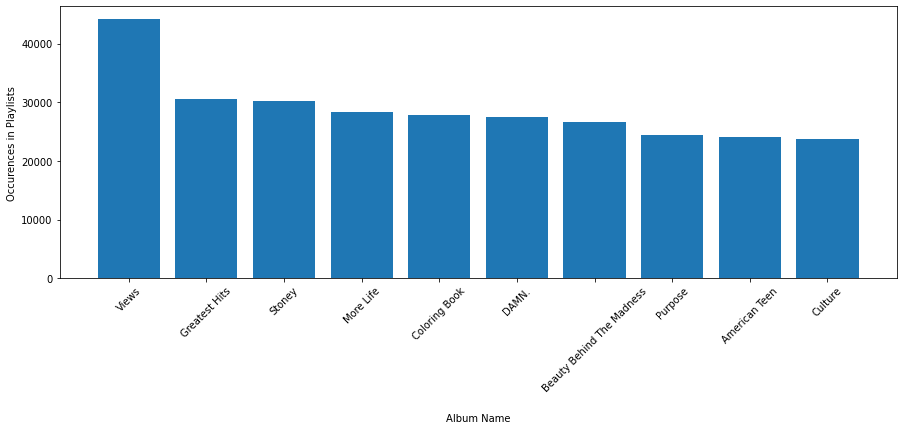

In [ ]:
albums = []
count = []
for k in top_albums:
    albums.append(k['album_name']) #replacing champID by champion name
    count.append(k['count'])
f, ax = plt.subplots(figsize=(15,5))
plt.bar(albums,count);
plt.xlabel("Album Name", labelpad = 20);
plt.xticks(rotation = 45);
plt.ylabel("Occurences in Playlists");

##Playlist Duration Vs Number of Followers

In [ ]:
dfp = dflist2[0].select('p_duration_ms', 'num_followers').toPandas()

In [ ]:
dfp['p_duration'] = dfp['p_duration_ms'].divide(60000)
del dfp['p_duration_ms']

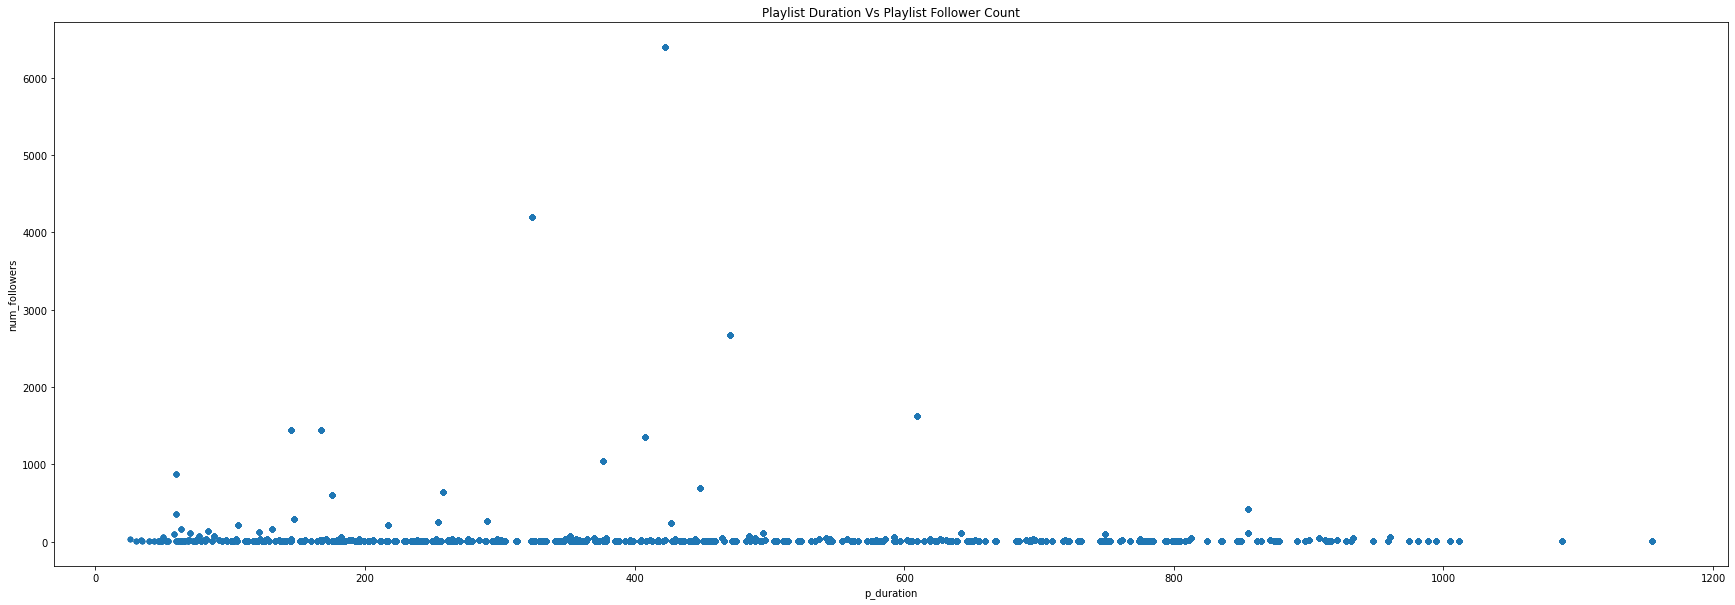

In [ ]:
dfp = dfp[dfp['num_followers']>5]
dfp.plot.scatter(x ='p_duration',y = 'num_followers', figsize = (30,10), title = 'Playlist Duration Vs Playlist Follower Count' )

##Playlist Variability Vs Number of Followers

In [ ]:
dfp = dflist2[0].select('num_tracks','num_artists', 'num_followers').toPandas()

In [ ]:
dfp['variability'] = dfp['num_tracks']/dfp['num_artists'] #variability is defined as the number of tracks in playlist divided by the number of artists in playlist

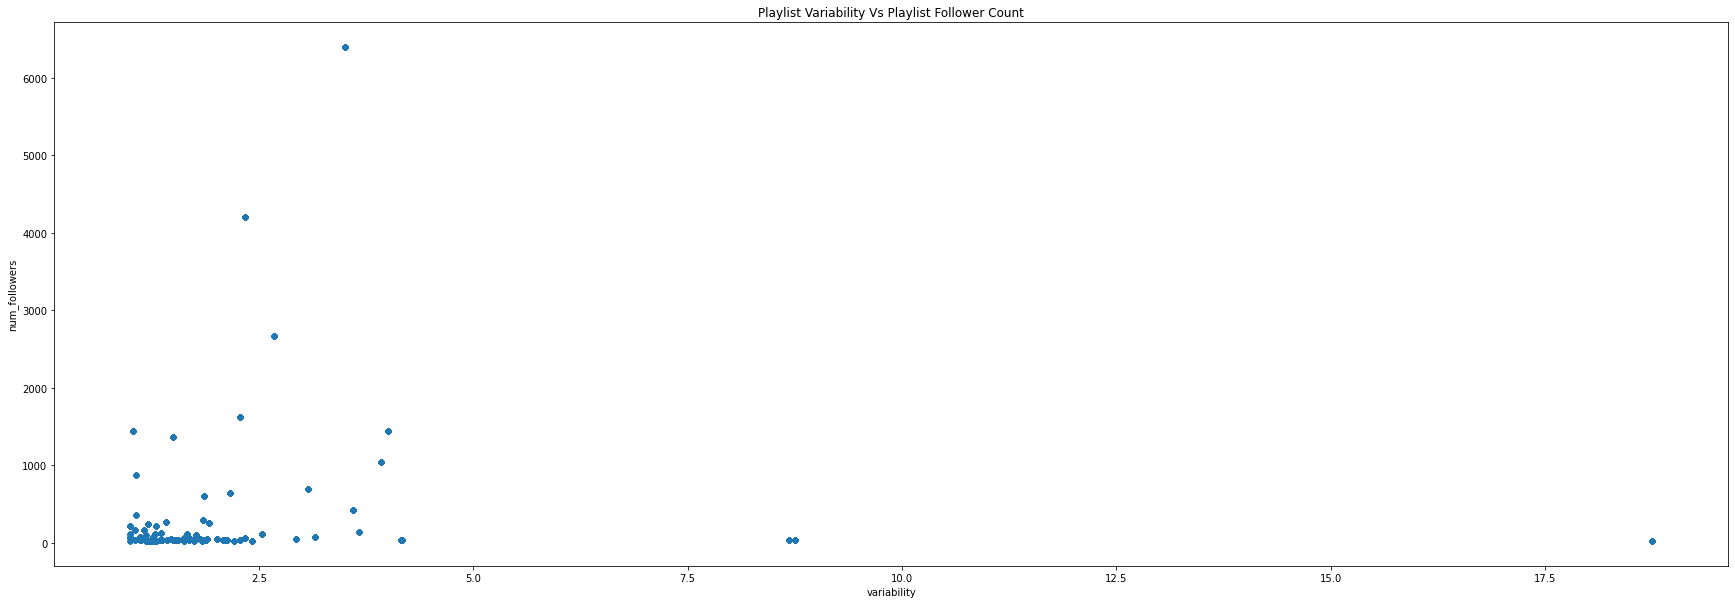

In [ ]:
dfp = dfp[dfp['num_followers']>5]
dfp.plot.scatter(x ='variability',y = 'num_followers', figsize = (30,10), title = 'Playlist Variability Vs Playlist Follower Count' )

#Collaborative Recommendation Systems

##Grouping by Playlist

In [ ]:
def playlist_track_mapper (record): #maps data to ((playlist id, playlist follower count), track name, album name, artist name)
  return ((record['pid'],record['num_followers']),(record['track_name'],record['album_name'],record['artist_name']))

In [ ]:
pid_tracks = data_rdd.map(playlist_track_mapper).groupByKey().mapValues(list) #applies mapping and groups by PID

##Track Recommender (Playlist Continuation)

In [ ]:
def track_recommendation_system(track_artist_list): #Takes in a list of (Track, Artist) Tuples and generates track recommendations
  #Input Checks
  if type(track_artist_list) == tuple:
    #if input is tuple turn into a list of one item
    track_artist_list = [track_artist_list]
  elif type(track_artist_list) != list:
    return 'Please Enter Input in the form of a list of (Track,Artist) Tuples or a single (Track,Artist) Tuple'
  def track_count_mapper (record): # creates a tuple of song, artist and number of occurences
    tracks = record[1]
    return list(map(lambda x: ((x[0],x[2]),1),tracks))
  #filtering the playlist grouped tracks by only including playlists which contain the user-input tracks
  #the filtered playlists are then sorted so the playlists with the greatest number of included tracks are at the top
  #all track names are converted to lower case to avoid false negatives
  filtered_pid_tracks =  pid_tracks.filter(lambda x: len(set([(i[0].lower(),i[1].lower()) for i in track_artist_list]) & set([(j[0].lower(),j[2].lower()) for j in x[1]]))>0).sortBy(lambda x: len(set([(i[0].lower(),i[1].lower()) for i in track_artist_list]) & set([(j[0].lower(),j[2].lower()) for j in x[1]])),ascending = False)
  
  if len(filtered_pid_tracks.collect()) == 0: #check for if no matches occur
    return "No matches, Try to enter the full song title."
  #taking the top 100 filtered and sorted playlists, and then sorting them by number of followers 
  top_playlists = filtered_pid_tracks.toDF().limit(100).rdd.map(lambda x: ((x['_1']['_1'],x['_1']['_2']),[(i['_1'],i['_2'],i['_3']) for i in x['_2']])).sortBy(lambda x : x[0][1],ascending = False).toDF().limit(20).rdd.map(lambda x: ((x['_1']['_1'],x['_1']['_2']),[(i['_1'],i['_2'],i['_3']) for i in x['_2']]))
  #taking the 20 most occuring songs in the top 100 playlists as recommendations
  top_songs = top_playlists.flatMap(track_count_mapper).reduceByKey(lambda a,b: a+b).filter(lambda x: not x[0] in track_artist_list).sortBy(lambda x: x[1],ascending = False).take(20)
  return list(map(lambda x: x[0],top_songs))

In [ ]:
track_recommendation_system([('On Melancholy Hill', 'Gorillaz'),\
                             ('Feels Like We Only Go Backwards', 'Tame Impala'),\
                             ('Stolen Dance', 'Milky Chance'),\
                             ('Clint Eastwood', 'Gorillaz'),\
                             ('Breezeblocks', 'alt-J')])

[('Tongue Tied', 'Grouplove'),
 ('Cigarette Daydreams', 'Cage The Elephant'),
 ("Why'd You Only Call Me When You're High?", 'Arctic Monkeys'),
 ('Someday', 'The Strokes'),
 ('What You Know', 'Two Door Cinema Club'),
 ('Riptide', 'Vance Joy'),
 ('Do I Wanna Know?', 'Arctic Monkeys'),
 ('Ways To Go', 'Grouplove'),
 ('Come a Little Closer', 'Cage The Elephant'),
 ('Shake Me Down', 'Cage The Elephant'),
 ('Young Folks', 'Peter Bjorn and John'),
 ('Walking On A Dream', 'Empire of the Sun'),
 ('Float On', 'Modest Mouse'),
 ('Midnight City', 'M83'),
 ('Two Weeks', 'Grizzly Bear'),
 ('Mr. Brightside', 'The Killers'),
 ('Flashed Junk Mind', 'Milky Chance'),
 ('Purple Yellow Red and Blue', 'Portugal. The Man'),
 ('San Francisco', "The Mowgli's"),
 ('Left Hand Free', 'alt-J')]

##Track Recommendation (Artist Based)


In [ ]:
def track_recommendation_system_2(artist_list, num_tracks): #Takes in a list of Artists and generates track recommendations
  #Input Checks
  if type(artist_list) == str:
    artist_list = [artist_list]
  elif type(artist_list) != list:
    return 'Please Enter Input in the form of a list of Artists or a single Artist)'
  elif type(num_tracks) != int:
    return 'Please enter an integer for the number of required tracks'
  def track_count_mapper (record): #Mapper that maps a record to Song, Artist, and number of occurences
    tracks = record[1]
    return list(map(lambda x: ((x[0],x[2]),1),tracks))
  #filtering playlists so that only playlists with the tracks from input artist list are included
  #the filtered playlists are then sorted so the playlists with the greatest number of included tracks are at the top
  filtered_pid_tracks =  pid_tracks.filter(lambda x: len(set([i.lower() for i in artist_list]) & set([j[2].lower() for j in x[1]]))>0).sortBy(lambda x: len(set([i.lower() for i in artist_list]) & set([j[2].lower() for j in x[1]])),ascending = False)
  if len(filtered_pid_tracks.collect()) == 0: #check for if no matches occur
    return "No matches, Try to enter the full song title."
  #taking the top 100 filtered and sorted playlists, and then sorting them by number of followers
  top_playlists = filtered_pid_tracks.toDF().limit(100).rdd.map(lambda x: ((x['_1']['_1'],x['_1']['_2']),[(i['_1'],i['_2'],i['_3']) for i in x['_2']])).sortBy(lambda x : x[0][1],ascending = False).toDF().limit(20).rdd.map(lambda x: ((x['_1']['_1'],x['_1']['_2']),[(i['_1'],i['_2'],i['_3']) for i in x['_2']]))
  #taking the N most occuring songs in the top 100 playlists as recommendations 
  if num_tracks>100 or num_tracks < 1:
    return 'Please enter a number of tracks between 0 and 100'
  top_songs = top_playlists.flatMap(track_count_mapper).reduceByKey(lambda a,b: a+b).filter(lambda x: not x[0][1] in artist_list).sortBy(lambda x: x[1],ascending = False).take(num_tracks)
  return list(map(lambda x: x[0],top_songs))

In [ ]:
track_recommendation_system_2(['Radiohead','The Strokes','Arctic Monkeys'],30)

[('On Melancholy Hill', 'Gorillaz'),
 ('Feels Like We Only Go Backwards', 'Tame Impala'),
 ('Stolen Dance', 'Milky Chance'),
 ('Clint Eastwood', 'Gorillaz'),
 ('Breezeblocks', 'alt-J'),
 ('Intro', 'The xx'),
 ('Oxford Comma', 'Vampire Weekend'),
 ('Pumped Up Kicks', 'Foster The People'),
 ('Time to Pretend', 'MGMT'),
 ('Riptide', 'Vance Joy'),
 ('Cigarette Daydreams', 'Cage The Elephant'),
 ('Float On', 'Modest Mouse'),
 ('Young Folks', 'Peter Bjorn and John'),
 ('Lisztomania', 'Phoenix'),
 ('Scar Tissue', 'Red Hot Chili Peppers'),
 ('Maps', 'Yeah Yeah Yeahs'),
 ('1979', 'The Smashing Pumpkins'),
 ('Ways To Go', 'Grouplove'),
 ('When You Were Young', 'The Killers'),
 ('Lonely Boy', 'The Black Keys'),
 ('Tongue Tied', 'Grouplove'),
 ('Afraid', 'The Neighbourhood'),
 ('Midnight City', 'M83'),
 ('Gooey', 'Glass Animals'),
 ('Heart-Shaped Box', 'Nirvana'),
 ('Walking On A Dream', 'Empire of the Sun'),
 ('Feel Good Inc', 'Gorillaz'),
 ('Kids With Guns', 'Gorillaz'),
 ('Icky Thump', 'The Whi

##Album Recommender

In [ ]:
def album_recommendation_system(track_artist_list): #Takes in a list of (Track, Artist) Tuples and generates album recommendations
  #Input checks
  if type(track_artist_list) == tuple:
    track_artist_list = [track_artist_list]
  elif type(track_artist_list) != list:
    return 'Please Enter Input in the form of a list of (Track,Artist) Tuples or a single (Track,Artist) Tuple'
  def album_count_mapper (record): #mapper that outputs a tuple of album, artist, and 1
    tracks = record[1]
    return list(map(lambda x: ((x[1],x[2]),1),tracks))
  #filtering the playlist grouped tracks by only including playlists which contain the user-input tracks
  #the filtered playlists are then sorted so the playlists with the greatest number of included tracks are at the top
  #all track names are converted to lower case to avoid false negatives
  filtered_pid_tracks =  pid_tracks.filter(lambda x: len(set([(i[0].lower(),i[1].lower()) for i in track_artist_list]) & set([(j[0].lower(),j[2].lower()) for j in x[1]]))>0).sortBy(lambda x: len(set([(i[0].lower(),i[1].lower()) for i in track_artist_list]) & set([(j[0].lower(),j[2].lower()) for j in x[1]])),ascending = False)
  if len(filtered_pid_tracks.collect()) == 0:
    return "No matches, Try to enter the full song title."
  #taking the top 100 filtered and sorted playlists, and then sorting them by number of followers
  top_playlists = filtered_pid_tracks.toDF().limit(100).rdd.map(lambda x: ((x['_1']['_1'],x['_1']['_2']),[(i['_1'],i['_2'],i['_3']) for i in x['_2']])).sortBy(lambda x : x[0][1],ascending = False).toDF().limit(20).rdd.map(lambda x: ((x['_1']['_1'],x['_1']['_2']),[(i['_1'],i['_2'],i['_3']) for i in x['_2']]))
  #taking the N most occuring albums in the top 100 playlists as recommendations 
  top_albums = top_playlists.flatMap(album_count_mapper).reduceByKey(lambda a,b: a+b).sortBy(lambda x: x[1],ascending = False).take(20)
  return list(map(lambda x: x[0],top_albums))

In [ ]:
album_recommendation_system(('Bohemian Rhapsody - Remastered 2011', 'Queen'))

[('A Night At The Opera', 'Queen'),
 ('Appetite For Destruction', "Guns N' Roses"),
 ('Slippery When Wet', 'Bon Jovi'),
 ('Abbey Road', 'The Beatles'),
 ('Back In Black', 'AC/DC'),
 ('The Game', 'Queen'),
 ('Jazz', 'Queen'),
 ('Boston', 'Boston'),
 ('News Of The World', 'Queen'),
 ('American Pie', 'Don McLean'),
 ('Second Helping', 'Lynyrd Skynyrd'),
 ('Toys In The Attic', 'Aerosmith'),
 ("Pronounced' Leh-'Nerd 'Skin-'Nerd", 'Lynyrd Skynyrd'),
 ('Leftoverture', 'Kansas'),
 ('1984', 'Van Halen'),
 ('Escape', 'Journey'),
 ('Working Class Dog', 'Rick Springfield'),
 ('Hotel California (Remastered)', 'Eagles'),
 ('Hot Space', 'Queen'),
 ('Greatest', 'Bee Gees')]

##Artist Recommender

In [ ]:
def artist_recommendation_system(track_artist_list):  #Takes in a list of (Track, Artist) Tuples and generates artist recommendations
  #Input Checks
  if type(track_artist_list) == tuple:
    track_artist_list = [track_artist_list]
  elif type(track_artist_list) != list:
    return 'Please Enter Input in the form of a list of (Track,Artist) Tuples or a single (Track,Artist) Tuple'
  def album_count_mapper (record): #mapper that outputs a tuple of artist, and 1
    tracks = record[1]
    return list(map(lambda x: (x[2],1),tracks))
  #filtering the playlist grouped tracks by only including playlists which contain the user-input tracks
  #the filtered playlists are then sorted so the playlists with the greatest number of included tracks are at the top
  #all track names are converted to lower case to avoid false negatives
  filtered_pid_tracks =  pid_tracks.filter(lambda x: len(set([(i[0].lower(),i[1].lower()) for i in track_artist_list]) & set([(j[0].lower(),j[2].lower()) for j in x[1]]))>0).sortBy(lambda x: len(set([(i[0].lower(),i[1].lower()) for i in track_artist_list]) & set([(j[0].lower(),j[2].lower()) for j in x[1]])),ascending = False)
  if len(filtered_pid_tracks.collect()) == 0:
    return "No matches, Try to enter the full song title."
  #taking the top 100 filtered and sorted playlists, and then sorting them by number of followers
  top_playlists = filtered_pid_tracks.toDF().limit(100).rdd.map(lambda x: ((x['_1']['_1'],x['_1']['_2']),[(i['_1'],i['_2'],i['_3']) for i in x['_2']])).sortBy(lambda x : x[0][1],ascending = False).toDF().limit(20).rdd.map(lambda x: ((x['_1']['_1'],x['_1']['_2']),[(i['_1'],i['_2'],i['_3']) for i in x['_2']]))
  artist_list = list(map(list,zip(*track_artist_list)))[1]
  #taking the 20 most occuring artists in the top 100 playlists as recommendations after filtering out those from user input
  top_artists = top_playlists.flatMap(album_count_mapper).reduceByKey(lambda a,b: a+b).filter(lambda x: not x[0] in artist_list).sortBy(lambda x: x[1],ascending = False).take(20)
  return list(map(lambda x: x[0],top_artists))

In [ ]:
artist_recommendation_system(('No Surprises','Radiohead'))

['Coldplay',
 'Red Hot Chili Peppers',
 'Nirvana',
 'Muse',
 'The Smashing Pumpkins',
 'Mac Demarco',
 'Foo Fighters',
 'Banks',
 'The Strokes',
 'Air',
 'The Breeders',
 'Sugar Ray',
 'No Doubt',
 'Never Shout Never',
 'The Cure',
 'Phoenix',
 'Pixies',
 'Tame Impala',
 'alt-J',
 'The Velvet Underground']

##Grouping Data by Artist

In [ ]:
def artist_track_mapper (record): # maps data to ((artist name, track name), playlists the track occurs in, the number of followers of each playlist the track occurs in)
  return ((record['artist_name'],record['track_name']),(record['pid'],record['num_followers']))

In [ ]:
def artist_track_playlists_followers_mapper(record):# maps to ((artist name, track name), number of playlists track occurs in, Max number of followers of playlists the track occurs in)
  playlists, num_followers= list(map(list,zip(*record[1])))
  numfollowers = max(num_followers)
  numplaylists = len(playlists)
  return (record[0],(numplaylists,numfollowers))

In [ ]:
artist_tracks = data_rdd.map(artist_track_mapper).groupByKey().mapValues(list).map(artist_track_playlists_followers_mapper) #applies mapping and groups by artist name and track name

In [ ]:
test = artist_tracks.take(5)

##Artist-Based Playlist Generator

In [ ]:
def artist_playlist_generator(artist_list,playlist_size): #takes in artist list and required playlist size (n) and outputs N tracks
  #Input Checks
  if type(artist_list) == str:
    artist_list = [artist_list]
  elif type(artist_list) != list:
    return 'Please enter input in the form of a list of artists tuples or a single artist string'
  elif type(playlist_size) != int:
    return 'Please enter the playlist size as an integer '
  #filtering records so only those with artists from the artist list are present. then sorting by number of playlist occurences, taking the top 100 tracks, then sorting them by playlist follower count
  filtered_artist_tracks =  artist_tracks.filter(lambda x: x[0][0].lower() in [i.lower() for i in artist_list]).sortBy(lambda x: x[1][0],ascending = False).toDF().limit(100).rdd.map(lambda x: ((x['_1']['_1'],x['_1']['_2']),(x['_2']['_1'],x['_2']['_2']))).sortBy(lambda x : x[1][1],ascending = False)
  if playlist_size > 100 or playlist_size < 1:
    return 'Please enter a number between 1 and 100'
  #taking the top N tracks
  recommended_tracks = filtered_artist_tracks.toDF().limit(playlist_size).rdd.map(lambda x: (x['_1']['_2'],x['_1']['_1'])).collect()
  return recommended_tracks

In [ ]:
artist_playlist_generator(['Radiohead','The Strokes','Arctic Monkeys'],50)

[('Fluorescent Adolescent', 'Arctic Monkeys'),
 ('505', 'Arctic Monkeys'),
 ('Only Ones Who Know', 'Arctic Monkeys'),
 ('Crying Lightning', 'Arctic Monkeys'),
 ('Cornerstone', 'Arctic Monkeys'),
 ('My Propeller', 'Arctic Monkeys'),
 ('Do Me A Favour', 'Arctic Monkeys'),
 ("She's Thunderstorms", 'Arctic Monkeys'),
 ('2 + 2 = 5', 'Radiohead'),
 ('Do I Wanna Know?', 'Arctic Monkeys'),
 ('R U Mine?', 'Arctic Monkeys'),
 ('I Wanna Be Yours', 'Arctic Monkeys'),
 ('Last Nite', 'The Strokes'),
 ('Someday', 'The Strokes'),
 ('Creep', 'Radiohead'),
 ('Arabella', 'Arctic Monkeys'),
 ('You Only Live Once', 'The Strokes'),
 ('Mardy Bum', 'Arctic Monkeys'),
 ('Machu Picchu', 'The Strokes'),
 ('OBLIVIUS', 'The Strokes'),
 ('One For The Road', 'Arctic Monkeys'),
 ("Why'd You Only Call Me When You're High?", 'Arctic Monkeys'),
 ("Baby I'm Yours", 'Arctic Monkeys'),
 ('Idioteque', 'Radiohead'),
 ('Karma Police', 'Radiohead'),
 ('No. 1 Party Anthem', 'Arctic Monkeys'),
 ('High And Dry', 'Radiohead'),
 ('